# HybridNetv7EX Report

Jakob Balkovec<br>
Thu Sep 11th 2025<br>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
from matplotlib.patches import Patch
import matplotlib.image as mpimg

ROOT_DIR = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7EX/output'
PATHS = {
  'per_image_test': os.path.join(ROOT_DIR, 'test_per_image_metrics.csv'),
  'metrics': os.path.join(ROOT_DIR, 'metrics_expanded.csv'),
  'split': os.path.join(ROOT_DIR, 'metrics_logs/split_summary.csv'),
}

## Utility Functions

In [3]:
def get_color(d):
    if d < 0.4:
        return "red"
    elif d < 0.5:
        return "yellow"
    else:
        return "green"

def plot_scatter_per_img_dice(df):
    plt.figure(figsize=(10, 8))
    plt.scatter(
        df["dice"],
        df["idx"],
        c=df["color"],
        s=80,
        marker="o",
        edgecolor="k",
        alpha=0.9
    )

    plt.axvline(0.4, color="red", linestyle="--", alpha=0.7, linewidth=1.2)
    plt.axvline(0.5, color="green", linestyle="--", alpha=0.7, linewidth=1.2)

    plt.xlabel("Dice Score", fontsize=13)
    plt.ylabel("Image Index", fontsize=13)
    plt.title("Per-Image Dice Scores", fontsize=15, fontweight="bold")

    legend_elements = [
        Patch(facecolor="red", edgecolor="k", label="Dice < 0.4"),
        Patch(facecolor="yellow", edgecolor="k", label="0.4 ≤ Dice < 0.5"),
        Patch(facecolor="green", edgecolor="k", label="Dice ≥ 0.5"),
    ]
    plt.legend(handles=legend_elements, title="Score Ranges", loc="lower right", frameon=True)

    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

BANDS = {
    "loss": {
        "good": (0.0, 0.25),
        "mid":  (0.25, 0.45),
        "bad":  (0.45, float("inf")),
    },
    "dice": {
        "bad":  (0.0, 0.40),
        "mid":  (0.40, 0.60),
        "good": (0.60, 1.0),
    },
    "iou": {
        "bad":  (0.0, 0.30),
        "mid":  (0.30, 0.45),
        "good": (0.45, 1.0),
    },
    "pearson": {
        "bad":  (0.0, 0.30),
        "mid":  (0.30, 0.50),
        "good": (0.50, 1.0),
    },
}

BAND_COLORS = {"bad": "#F44336", "mid": "#FFC107", "good": "#4CAF50"}

def _get_epoch_x(df):
    if "epoch" in df.columns:
        return df["epoch"].values
    return (df.index.values + 1)

def _shade_bands(ax, metric, x_min, x_max, alpha=0.15):
    if metric not in BANDS:
        return

    for band in ("bad", "mid", "good"):
        lo, hi = BANDS[metric][band]
        ax.axhspan(lo, hi if hi != float("inf") else ax.get_ylim()[1],
                   color=BAND_COLORS[band], alpha=alpha, zorder=0, linewidth=0)

def plot_metric(df, metric, title=None, ylim=None):
    tr_col = f"train_{metric}"
    va_col = f"val_{metric}"
    if tr_col not in df.columns or va_col not in df.columns:
        raise ValueError(f"Expected columns '{tr_col}' and '{va_col}' in df")

    x = _get_epoch_x(df)
    y_tr = df[tr_col].values
    y_va = df[va_col].values

    fig, ax = plt.subplots(figsize=(8, 5))

    y_min = min(y_tr.min(), y_va.min())
    y_max = max(y_tr.max(), y_va.max())
    if ylim is None:
        if metric in ("dice", "iou", "pearson"):
            ylim = (0.0, 1.0)
        else:
            ylim = (max(0.0, y_min * 0.9), y_max * 1.1)

    ax.set_ylim(*ylim)
    _shade_bands(ax, metric, x_min=x.min(), x_max=x.max(), alpha=0.18)

    ax.plot(x, y_tr, marker="o", linewidth=1.8, markersize=5, label=f"train_{metric}")
    ax.plot(x, y_va, marker="s", linewidth=1.8, markersize=5, label=f"val_{metric}")

    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.set_title(title or f"{metric.capitalize()} (train vs val)")
    ax.grid(True, axis="both", linestyle="--", alpha=0.4)
    ax.legend(loc="best", frameon=True)

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    return fig, ax

def plot_panel(img):
    plt.figure(figsize=(10, 16))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Best Panel")
    plt.show()

In [4]:
per_image_test_df = pd.read_csv(PATHS['per_image_test'])
metrics_df = pd.read_csv(PATHS['metrics'])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7EX/output/test_per_image_metrics.csv'

## Per-Image Test Results

This is here to analyze per-image dice scores, and rule out the outliers.

#### Tail

In [3]:
sorted_per_img = per_image_test_df.sort_values('dice')
sorted_per_img.head(n=10)

,image_id,dice,iou,precision,recall,pearson
134,0760_1,2.568713e-10,2.568713e-10,0.0,0.0,0.080334
74,0445_1,3.732736e-10,3.732736e-10,0.0,0.0,0.398461
178,0914_1,5.437738e-10,5.437738e-10,0.0,0.0,0.502371
125,0716_1,6.035003e-10,6.035003e-10,0.0,0.0,0.166014
160,0844_1,7.530120e-10,7.530120e-10,0.0,0.0,0.303813
96,0559_1,7.880220e-10,7.880220e-10,0.0,0.0,0.394545
147,0800_1,1.007049e-09,1.007049e-09,0.0,0.0,0.360114
200,1005_1,1.326260e-09,1.326260e-09,0.0,0.0,0.125502
167,0868_3,1.592357e-09,1.592357e-09,0.0,0.0,0.350347
172,0890_1,1.773050e-09,1.773050e-09,0.0,0.0,0.074741


#### Head

In [13]:
sorted_per_img.tail(n=10)

,image_id,dice,iou,precision,recall,pearson
233,1187_1,1.0,1.0,0.0,0.0,0.0
234,1197_1,1.0,1.0,0.0,0.0,0.0
161,0848_1,1.0,1.0,0.0,0.0,0.0
236,1212_1,1.0,1.0,0.0,0.0,0.0
238,1217_1,1.0,1.0,0.0,0.0,0.0
239,1264_1,1.0,1.0,0.0,0.0,0.0
240,1277_1,1.0,1.0,0.0,0.0,0.0
241,1292_1,1.0,1.0,0.0,0.0,0.0
226,1110_1,1.0,1.0,0.0,0.0,0.0
199,1003_1,1.0,1.0,0.0,0.0,0.0


This doesn't really mean anything, since the tail is just images with no masks, and head is the images with the largest masks. Setting a threshold for dice scores to be above 0.5 seems reasonable. Anything above that is good, anything below that is considered a failure.

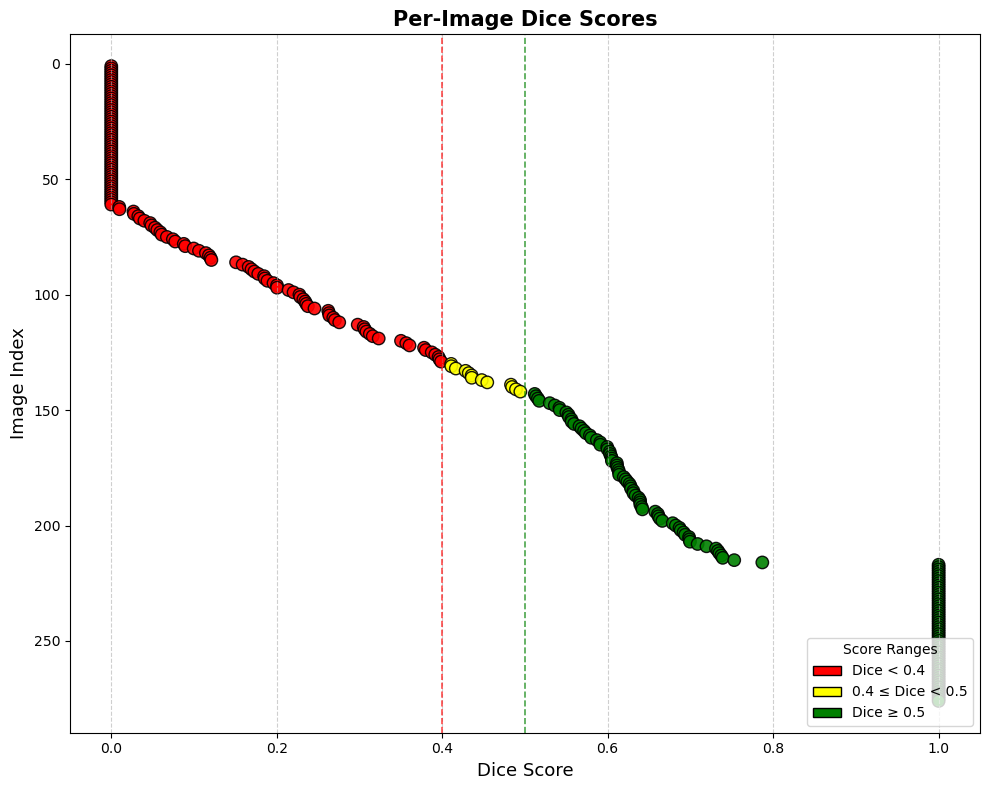

In [30]:
per_image_test_df["color"] = per_image_test_df["dice"].apply(get_color)
per_image_test_df = per_image_test_df.sort_values("dice").reset_index(drop=True)
per_image_test_df["idx"] = per_image_test_df.index + 1  # 1-based

plot_scatter_per_img_dice(per_image_test_df)

As I mentioned aboce, a dice score of 1 means that the predicted mask matches the ground truth perfectly. From my brief analysis, the images with a dice score of 1 have no masks/blank masks. A dice score of 0 means that there is no overlap at all:

- The model completely failed to detect the annotated lesions (missed all true lesions), 
- The model predicted lesions in entirely different regions of the fundus where none exist in the ground truth.

#### Removing Outliers

In [41]:
filtered_df = per_image_test_df[(per_image_test_df["dice"] > 0.05) & (per_image_test_df["dice"] < 0.99)]
print("New length: ", len(filtered_df), " vs. Old length: ", len(per_image_test_df))

New length:  146  vs. Old length:  276


`USING LOWER_BOUND == 0.05 && UPPER_BOUND == 0.99`

- I set the lower bound to be 0.05 to exclude the images where the model completely failed to detect any lesions. 
- I set the upper bound to be 0.99 to exclude the images where there are no lesions in the ground truth, which results in a dice score of 1. These outliers can skew the mean dice score and give a false impression of the model's performance.

`130 OUTLIERS`

Now that the `130` outliers have been identified and removed, we can caluculate a more accurate mean dice score. Note that these are not the dice scores obtained during training, but the dice scores calculated on the test set after training.

`SCALED UP`

If 276 images have 60 outliers, that means that 21.7% of the images are outliers. Scaling this up to the full dataset of 1820 images, we can expect around 395 images to be outliers. This is a significant portion of the dataset, and it highlights the importance of addressing these outliers in order to improve the overall performance of the model...

In [42]:
print("True MEAN: ", filtered_df["dice"].mean().round(3))


True MEAN:  0.447


Now this is the actual mean dice score after removing the outliers. it indicates poor performance, but this is expected given the difficulty of the task and the presence of many challenging images in the dataset...It's not too far off from the mean dice score over all images, which was 0.47. This suggests that the outliers were not drastically skewing the overall performance metrics, but their removal does provide a clearer picture of the model's capabilities on more typical cases.

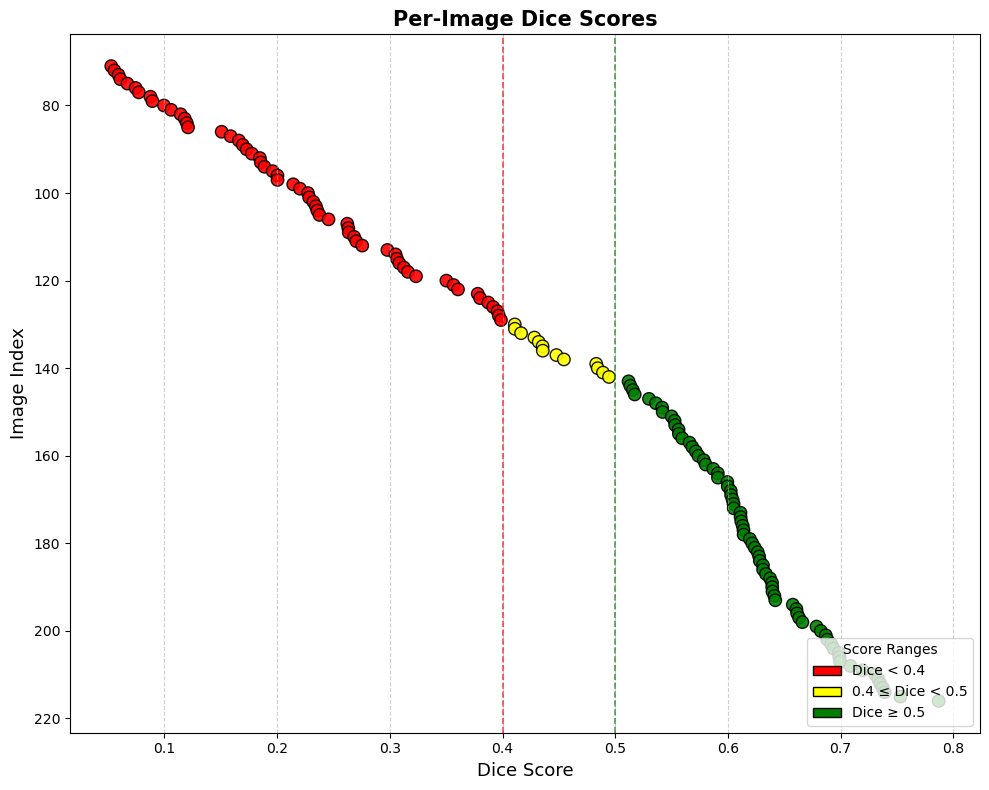

In [43]:
plot_scatter_per_img_dice(filtered_df)

## Standard Metrics

In [58]:
metrics_df.head(n=18)

,epoch,train_loss,val_loss,train_dice,val_dice,train_iou,val_iou,train_pearson,val_pearson
0,1,0.784197,0.461107,0.107996,0.144745,0.058612,0.089630,0.232279,0.215400
1,2,0.619675,0.457169,0.349640,0.419333,0.211886,0.332433,0.398610,0.318247
2,3,0.602261,0.427482,0.647053,0.325293,0.478292,0.249430,0.749195,0.281293
3,4,0.498969,0.441855,0.597506,0.417497,0.554020,0.324347,0.121087,0.344949
4,5,0.435537,0.447066,0.274577,0.385587,0.159705,0.312516,0.368592,0.283093
5,6,0.403178,0.474834,0.405518,0.482119,0.265018,0.399273,0.569687,0.357849
6,7,0.371233,0.464321,0.313173,0.497858,0.215393,0.413230,0.423612,0.359454
7,8,0.347218,0.467307,0.489693,0.489108,0.338966,0.404459,0.548484,0.352323
8,9,0.329015,0.446409,0.472807,0.445165,0.311935,0.356861,0.539199,0.341162
9,10,0.324979,0.509377,0.149821,0.499226,0.081693,0.424889,0.526397,0.365339


#### Dice

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation Dice Over Epochs'}, xlabel='Epoch', ylabel='Dice'>)

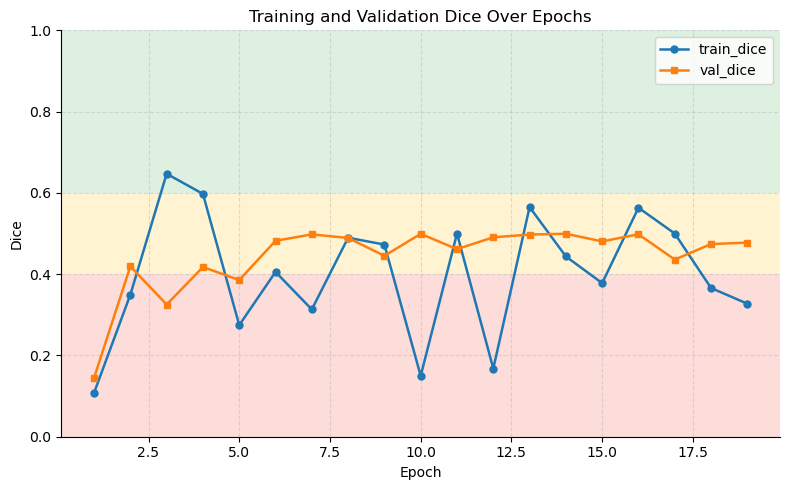

In [53]:
plot_metric(metrics_df, "dice", title="Training and Validation Dice Over Epochs")

#### IoU

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation IoU Over Epochs'}, xlabel='Epoch', ylabel='Iou'>)

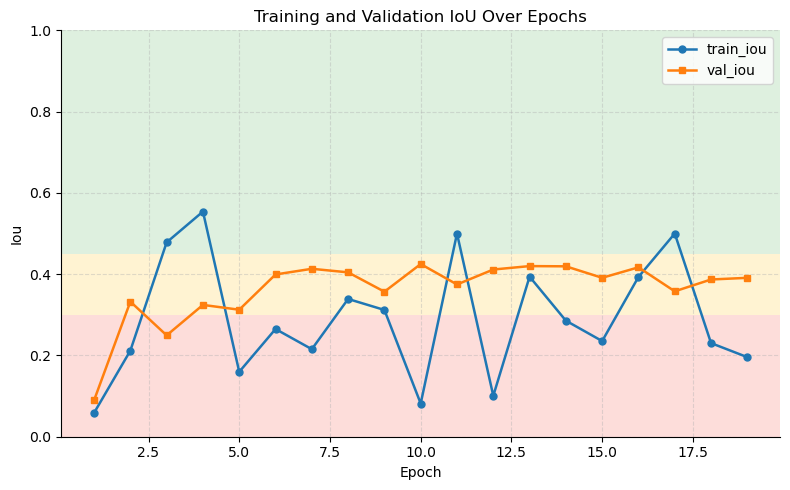

In [54]:
plot_metric(metrics_df, "iou", title="Training and Validation IoU Over Epochs")

#### Pearson's R

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': "Training and Validation Pearson's R Over Epochs"}, xlabel='Epoch', ylabel='Pearson'>)

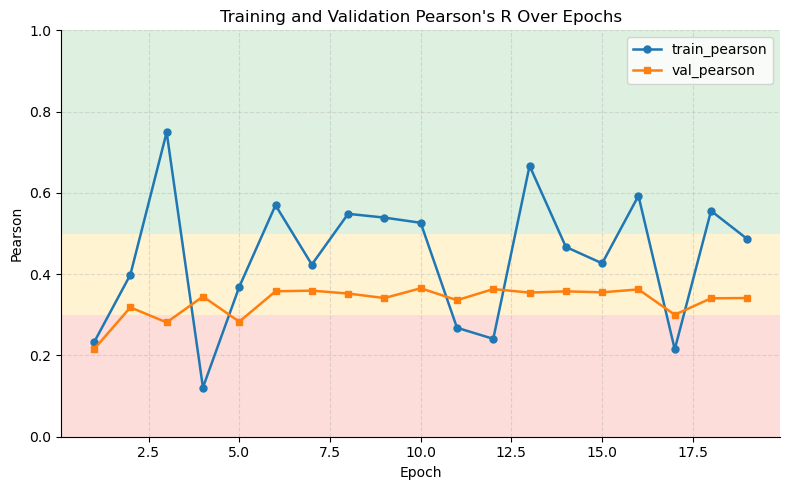

In [55]:
plot_metric(metrics_df, "pearson", title="Training and Validation Pearson's R Over Epochs")

The metrics don't look horrible, but they're not great either. This could be a mild case of overfitting I guess, but I think a bigger problem is that the model is just not powerful enough to capture the complexity of the data. The training and validation metrics are pretty close, which suggests that the model is learning something useful, but it's not learning it well enough to generalize to new data...

## Low-Dice Panels

#### Best

The panels with high dice (< 0.95) are not worth plotting since they're just images with no lesions. The model predicts no lesions, which is correct, but the dice score is 1 because there are no true positives. I plotted 1 just an example.

Note that the grid pattern is as follows:

| IMG + M1 | PRED M1   | PRED  M2  |
|------|------|------|
| IMG + M2 | IMG + M3 | PRED M3 |


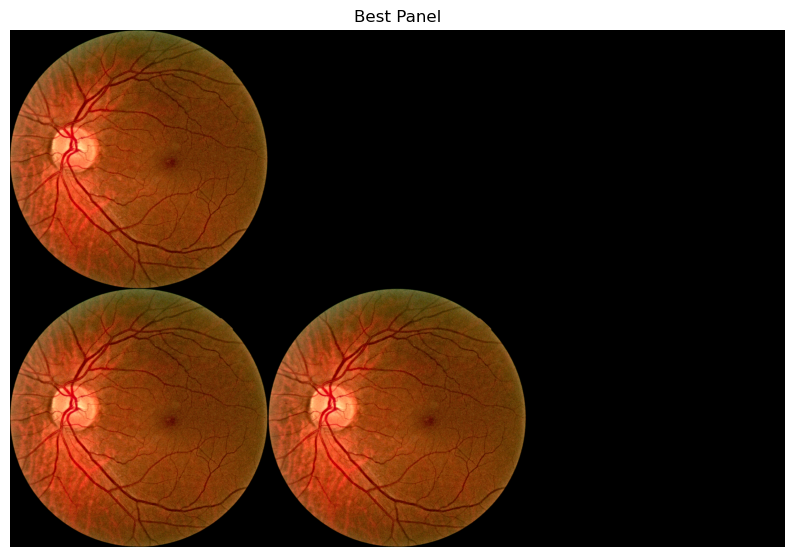

In [ ]:
path = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7EX/output/error_analysis_EX/best/00_1836_1_dice1.000.png'
img = mpimg.imread(path)



#### Worst

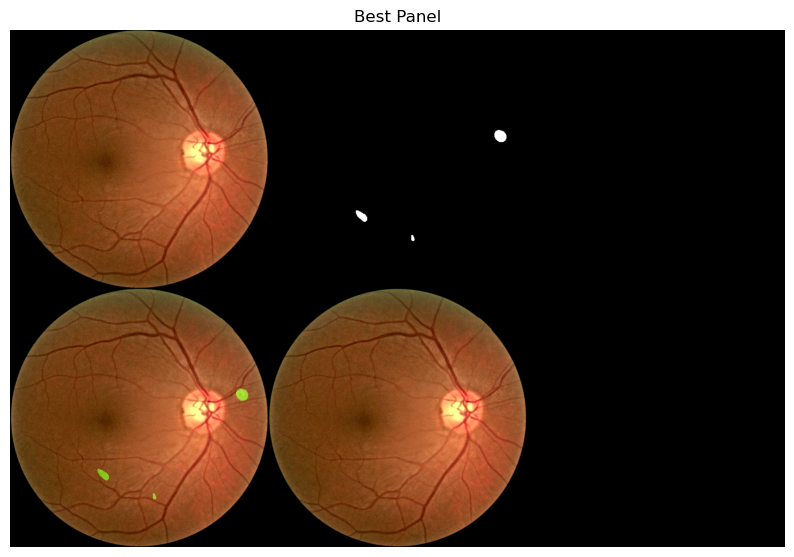

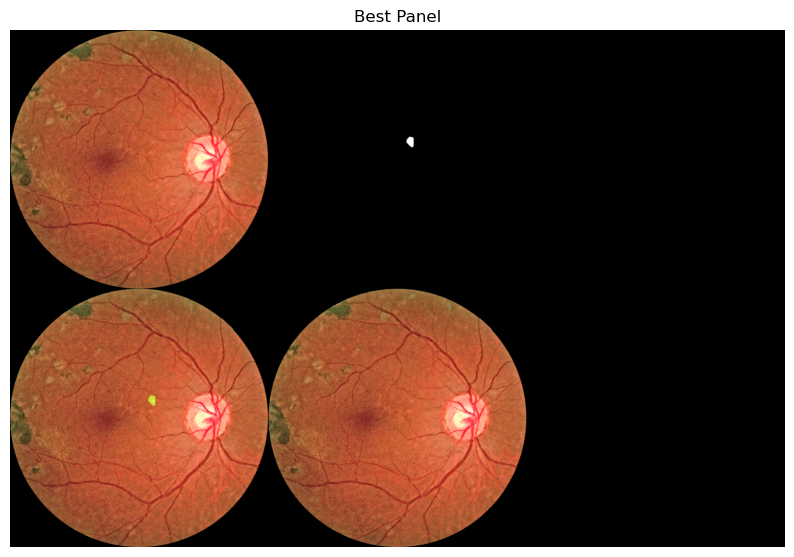

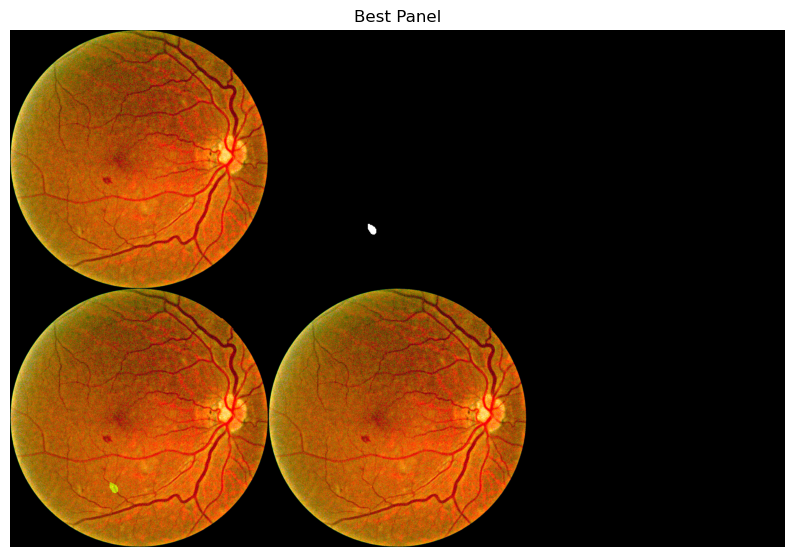

In [72]:
PANEL1 = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7EX/output/error_analysis_EX/worst/03_0644_1_dice0.000.png'
PANEL2 = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7EX/output/error_analysis_EX/worst/15_0526_1_dice0.000.png'
PANEL3 = r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7EX/output/error_analysis_EX/worst/13_0877_1_dice0.000.png'

plot_panel(mpimg.imread(PANEL1))
plot_panel(mpimg.imread(PANEL2))
plot_panel(mpimg.imread(PANEL3))

So the goal of this was to identify pattern(s) that hurt the dice score. I don't really see a definitive pattern, but I do see a common theme, that is if the lesion is relatively small, e.g. meaning a lot of background, the model tends to miss it/struggle. This is especially true if the lesion is in a tricky spot, like near the optic disc or fovea. The model seems to have a hard time distinguishing between actual lesions and other features of the retina, like blood vessels or reflections.

I'm curious to see if Daniel and Alyssa notice the same patterns when they do their analysis. It would be interesting to see if they come to the same conclusions, or if they notice different things that I missed...

## Further Investigation

Since I felt like this wasn't enough, I decided to compile a list of images with low (close to 0) dice score and investigate them further. I was mostly focused on predicted masks vs ground truth masks. 

```
image_ids_zero = ["0065_1", "0128_3", "0222_1", "0323_1", "0345_1", "0445_1", "0550_1", "0559_1", "0569_1", ...]
imgaes_ids_low = image_ids = ["0021_1", "0054_3", "0065_1", "0083_3", "0112_1", "0119_1", "0123_3", "0128_3", ...]

```



#### Zero Dice Breakdown

In [76]:
zero_dice_df = pd.read_csv(r'/Users/jbalkovec/Desktop/DR/experiments/model_logs/v7EX/output/per_image_analysis/zero_dice_breakdown.csv')

In [ ]:
case_counts = zero_dice_df["case"].value_counts()
print("\nCounts per failure type:\n", case_counts)


Counts per failure type:
 case
B_GT_nonempty_PRED_empty    21
A_GT_empty_PRED_nonempty     7
C_disjoint                   2
Name: count, dtype: int64


Each "case" describes why the Dice score is 0:
- `A_GT_empty_PRED_nonempty` means Ground truth mask is empty (no lesions),
  but the model predicted lesions anyway  = false positives.

- `B_GT_nonempty_PRED_empty` means Ground truth mask has lesions,
  but the model predicted nothing = false negatives.

- `C_disjoint` means Both GT and prediction are non-empty,
  but they do not overlap at all = mislocalization (wrong region).

In [78]:
case_percent = zero_dice_df["case"].value_counts(normalize=True) * 100
print("\nPercentages per failure type:\n", case_percent)


Percentages per failure type:
 case
B_GT_nonempty_PRED_empty    70.000000
A_GT_empty_PRED_nonempty    23.333333
C_disjoint                   6.666667
Name: proportion, dtype: float64


Out of all zero-Dice cases, the majority (70%) are `B_GT_nonempty_PRED_empty`, meaning the model completely missed lesions that were present in the ground truth (false negatives). A smaller portion (23%) are `A_GT_empty_PRED_nonempty`, where the model predicted lesions in images with no annotated lesions (false positives). Finally, a minority (~7%) are `C_disjoint`, where both ground truth and predictions contained lesion pixels but with no spatial overlap, this indicates mislocalization rather than total absence.

In [79]:
print("\nGround truth pixel stats:")
print(zero_dice_df["gt_pixels"].describe())


Ground truth pixel stats:
count       30.000000
mean      5797.533333
std       6207.913547
min          0.000000
25%        914.250000
50%       3046.000000
75%      10422.500000
max      24338.000000
Name: gt_pixels, dtype: float64


In [84]:
print("\nPrediction pixel stats:")
zero_dice_df["pred_pixels"].describe()


Prediction pixel stats:


count      30.000000
mean      388.000000
std       710.672144
min         0.000000
25%         0.000000
50%         0.000000
75%       291.000000
max      2314.000000
Name: pred_pixels, dtype: float64

`[OUTPUT 1 — Ground Truth]`
Looking at the ground truth masks, lesion sizes are all over the place. On average, the failed cases had around 5800 pixels worth of lesions, but the spread is huge (+/-6200). Some images had no lesions at all, while the biggest had more than 24,000 pixels labeled. The distribution is skewed: the median is ~3000, but a quarter of the cases jump above 10,000. This shows that failures happen both when lesions are tiny (easy to miss) and when they’re really large (sometimes the model just doesn’t predict anything). That kind of goes against my earlier assumption that only small lesions were being overlooked.


`[OUTPUT 2 — Predictions]`
For the predictions in these zero-dice cases, the model usually marks very little or nothing compared to the ground truth. The average was only about 388 pixels, and the variation across cases was pretty big too. But the skew is obvious: the median is literally 0, and three-quarters of the cases had fewer than 300 pixels predicted. A handful of outliers reached 2000+ pixels, but those were rare. Overall, it looks like the model is being too conservative, leaning towards predicting nothing or very small blobs instead of matching the ground truth lesions.

For reference: Our images have a resolution of 1280x1280 = 1,638,400 pixels. So even the largest lesions (24,000 pixels) only cover about 1.5% of the image area, while the average predicted lesion size (388 pixels) is a tiny 0.024% of the image. This highlights how small and sparse these lesions are relative to the full image, which likely contributes to the model's difficulty in accurately detecting them.

## Split

This is here just to assure you that the split was fair...

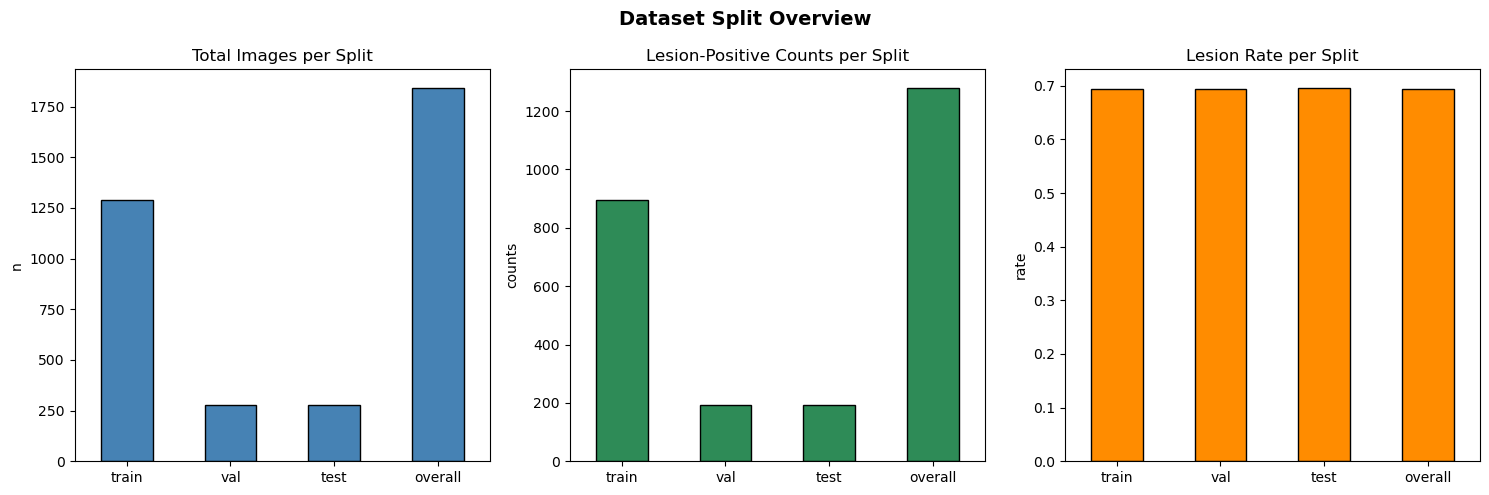

In [ ]:
split_df = pd.read_csv(PATHS['split'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

split_df.set_index("name")["n"].plot(
    kind="bar", ax=axes[0], color="steelblue", edgecolor="black"
)
axes[0].set_title("Total Images per Split")
axes[0].set_ylabel("n")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=0)

split_df.set_index("name")["counts"].plot(
    kind="bar", ax=axes[1], color="seagreen", edgecolor="black"
)
axes[1].set_title("Lesion-Positive Counts per Split")
axes[1].set_ylabel("counts")
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=0)

split_df.set_index("name")["rates"].plot(
    kind="bar", ax=axes[2], color="darkorange", edgecolor="black"
)
axes[2].set_title("Lesion Rate per Split")
axes[2].set_ylabel("rate")
axes[2].set_xlabel("")
axes[2].tick_params(axis="x", rotation=0)

plt.suptitle("Dataset Split Overview", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Solutions

Right now the main issue seems to be that the model is too conservative, it often predicts nothing even when lesions are there. A few directions are worth trying that don’t touch the architecture too much. 

One is to adjust the data pipeline: make sure patches with lesions are oversampled so the model sees more positives, and also include tricky negatives where it tends to hallucinate. 

Multi-scale augmentation can help too, since lesions come in very different sizes. 

Another lever is post-processing: simple steps like minimum-area filtering, hole filling, or small morphological operations can clean up predictions without retraining. 

On the regularization side, adding a bit of dropout in the decoder and relying on early stopping (instead of running for many more epochs) can keep validation Dice from flattening out while train loss keeps dropping. 

And finally, inference tricks like light test-time augmentation (flips and rotations) or even ensembling checkpoints can squeeze out a few extra points.

---
Jakob Balkovec